# Particle Filter (PF) Demo

Demonstrates Particle Filter with non-linear Range-Bearing tracking:
- Linear motion (constant velocity)
- Non-linear observations (range/bearing in polar coordinates)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pf import ParticleFilter
from range_bearing_model import RangeBearingModel

tf.random.set_seed(42)
np.random.seed(42)

2025-11-18 15:08:14.985181: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Generate Data

In [2]:
# Create model and generate trajectory
dt = 1.0
model = RangeBearingModel(
    dt=dt, 
    process_noise_std_pos=0.1, 
    process_noise_std_vel=0.1,
    range_noise_std=50.0, 
    bearing_noise_std=0.005, 
    seed=42
)

T = 100
true_states, obs = model.simulate_trajectory(T=T)

print(f"Generated {T} observations")
print(f"True states: {true_states.shape}, Observations: {obs.shape}")

Generated 100 observations
True states: (4, 101), Observations: (2, 100)


## 2. Define Functions for Particle Filter

In [3]:
# State transition: x_t = A @ x_{t-1}
def state_transition_fn(x, u=None):
    A_float64 = tf.cast(model.A, tf.float64)
    return tf.matmul(A_float64, x)

# Observation: z = [range, bearing]
def observation_fn(x):
    x_pos, y_pos = x[0, 0], x[2, 0]
    r = tf.sqrt(x_pos**2 + y_pos**2)
    theta = tf.atan2(y_pos, x_pos)
    return tf.stack([r, theta])[:, tf.newaxis]

# Process noise sampler: sample from N(0, Q)
def process_noise_sampler(num_samples):
    """Sample process noise from N(0, Q)"""
    noise = tf.random.normal([4, num_samples], dtype=tf.float64)
    Q_sqrt = tf.linalg.cholesky(tf.cast(model.Q, tf.float64))
    return tf.matmul(Q_sqrt, noise)

# Observation likelihood: RETURNS exp(log p(z|x)) for numerical stability
# The PF update function now handles log-sum-exp internally
def observation_likelihood_fn(z, x):
    """Compute p(z|x) = N(z; h(x), R) - returns likelihood (not log)"""
    # Predict observation from state
    z_pred = observation_fn(x)
    
    # Compute innovation
    innovation = z - z_pred
    
    # Handle angle wrapping for bearing (second component)
    bearing_diff = innovation[1, 0]
    bearing_diff = tf.atan2(tf.sin(bearing_diff), tf.cos(bearing_diff))
    innovation = tf.stack([innovation[0, 0], bearing_diff])[:, tf.newaxis]
    
    # Compute Gaussian log-likelihood: log p(z|x) = -0.5 * innovation^T R^{-1} innovation
    R = tf.cast(model.R, tf.float64)
    R_inv = tf.linalg.inv(R)
    
    mahalanobis = tf.matmul(tf.matmul(tf.transpose(innovation), R_inv), innovation)
    log_likelihood = -0.5 * mahalanobis[0, 0]
    
    # Return exp(log_likelihood) - the PF update will convert back to log with stability
    # We keep this as likelihood (not log) to maintain interface compatibility
    likelihood = tf.exp(tf.clip_by_value(log_likelihood, -700.0, 700.0))
    
    return likelihood

# Initial state sampler: sample from initial distribution
def x0_sampler(num_samples):
    """Sample initial states from N(x0, Sigma0)"""
    x0 = tf.cast(true_states[:, 0:1], tf.float64)
    Sigma0 = tf.eye(4, dtype=tf.float64) * 100.0
    Sigma0_sqrt = tf.linalg.cholesky(Sigma0)
    
    noise = tf.random.normal([4, num_samples], dtype=tf.float64)
    samples = x0 + tf.matmul(Sigma0_sqrt, noise)
    
    return samples

print("Functions defined for Particle Filter")

Functions defined for Particle Filter


## 3. Initialize and Run Particle Filter

In [5]:
# Initialize Particle Filter
pf = ParticleFilter(
    state_transition_fn=state_transition_fn,
    observation_fn=observation_fn,
    process_noise_sampler=process_noise_sampler,
    observation_likelihood_fn=observation_likelihood_fn,
    x0_sampler=x0_sampler,
    num_particles=1000,
    resample_method='multinomial',
    dtype=tf.float64
)

In [7]:
# Run filter with detailed tracking for degeneracy analysis
obs_float64 = tf.cast(obs, tf.float64)
results = pf.filter(obs_float64, return_details=True)
filtered_states, predicted_states, particles_history, weights_history, ess_history, resample_history, ancestry_history = results

print(f"Filtered states: {filtered_states.shape}")
print(f"Particles history: {particles_history.shape}")
print(f"Weights history: {weights_history.shape}")
print(f"ESS history: {ess_history.shape}")

TypeError: in user code:

    File "/Users/chunchaoma/Desktop/ml_simulation_research/ekf_ukf_pf/pf.py", line 382, in filter  *
        resample_history.append(tf.constant(1.0 if resampled else 0.0, dtype=self.dtype))

    TypeError: Expected float64, but got Tensor("cond/Identity:0", shape=(), dtype=float32) of type 'SymbolicTensor'.


In [ ]:
# Run filter with detailed tracking for degeneracy analysis
obs_float64 = tf.cast(obs, tf.float64)
results = pf.filter(obs_float64, return_details=True)
filtered_states, predicted_states, particles_history, weights_history, ess_history, resample_history, ancestry_history = results

print(f"Filtered states: {filtered_states.shape}")
print(f"Particles history: {particles_history.shape}")
print(f"Weights history: {weights_history.shape}")
print(f"ESS history: {ess_history.shape}")

Filtered states: (4, 101)
Particles history: (4, 1000, 101)
Weights history: (1000, 101)
ESS history: (101,)


In [18]:
ancestry_history

<tf.Tensor: shape=(1000, 101), dtype=int32, numpy=
array([[  0, 461, 814, ..., 148, 617, 813],
       [  1,  55, 581, ..., 162, 444, 205],
       [  2, 428, 140, ..., 814, 289,   9],
       ...,
       [997, 353, 999, ..., 444, 944, 717],
       [998, 696, 408, ..., 379, 852, 540],
       [999, 307, 671, ..., 391,  57, 253]], dtype=int32)>

## 4. Evaluate Performance

In [19]:
# Convert to float32 for comparison
filtered_states_f32 = tf.cast(filtered_states, tf.float32)

# Position RMSE
pos_error_filtered = tf.sqrt(
    (filtered_states_f32[0, 1:] - true_states[0, 1:])**2 +
    (filtered_states_f32[2, 1:] - true_states[2, 1:])**2
)

rmse_filtered = tf.sqrt(tf.reduce_mean(pos_error_filtered**2))

print("\nPerformance (Position RMSE):")
print(f"  Filtered:  {rmse_filtered.numpy():.2f}")


Performance (Position RMSE):
  Filtered:  318.00


## 5. Visualize Results

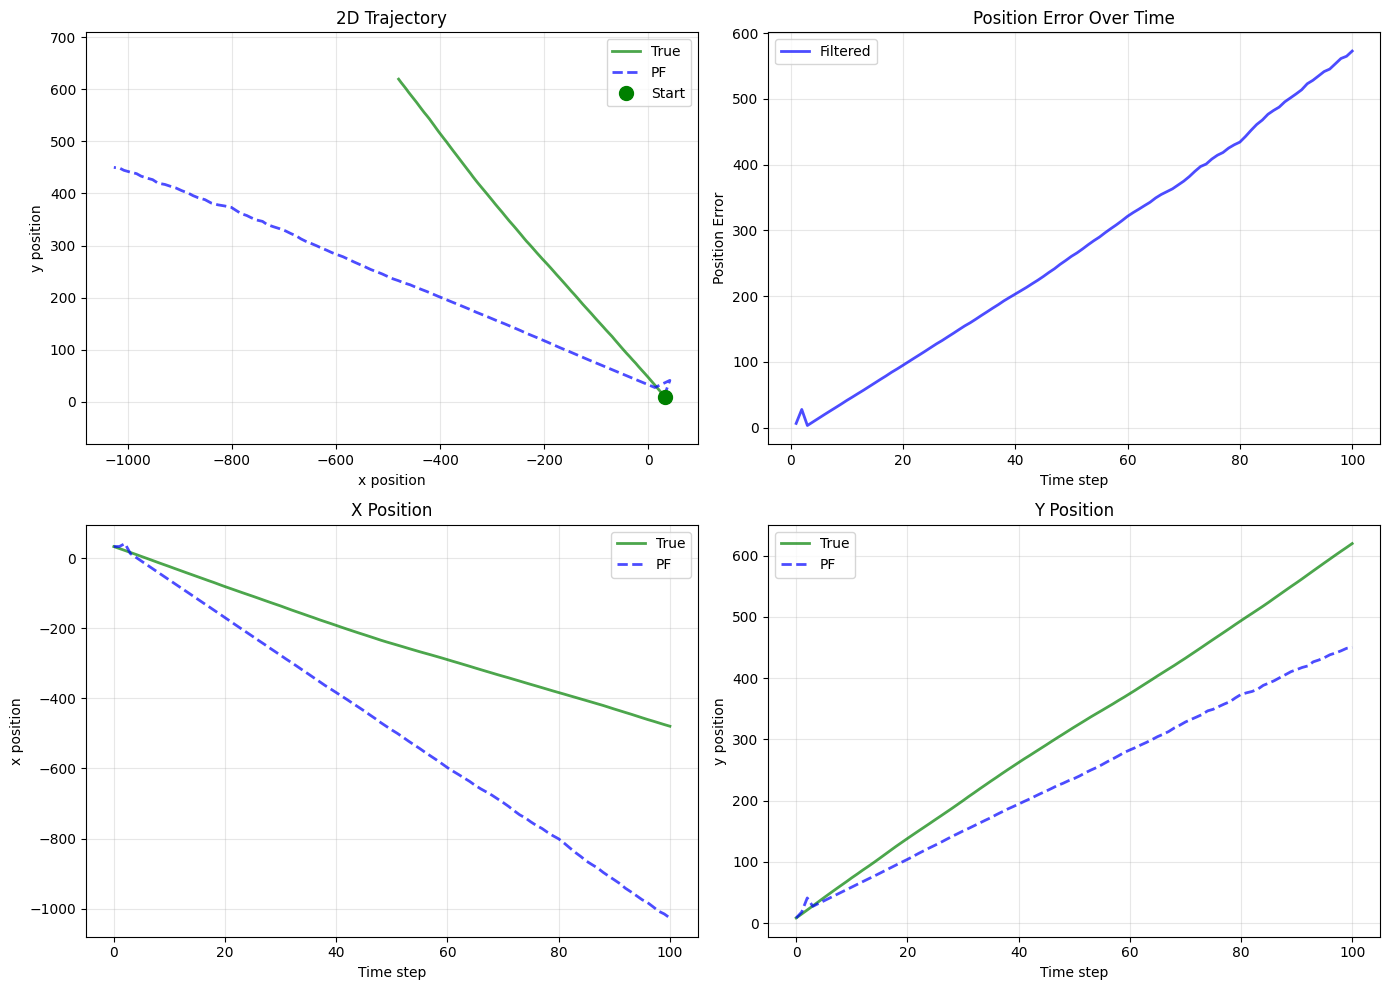

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Convert filtered states to numpy for plotting
filtered_np = filtered_states_f32.numpy()
true_np = true_states.numpy()

# 2D Trajectory
ax = axes[0, 0]
ax.plot(true_np[0, :], true_np[2, :], 'g-', linewidth=2, label='True', alpha=0.7)
ax.plot(filtered_np[0, :], filtered_np[2, :], 'b--', linewidth=2, label='PF', alpha=0.7)
ax.plot(true_np[0, 0], true_np[2, 0], 'go', markersize=10, label='Start')
ax.set_xlabel('x position')
ax.set_ylabel('y position')
ax.set_title('2D Trajectory')
ax.grid(True, alpha=0.3)
ax.legend()
ax.axis('equal')

# Position Error
ax = axes[0, 1]
time_steps = np.arange(1, T+1)
ax.plot(time_steps, pos_error_filtered.numpy(), 'b-', linewidth=2, label='Filtered', alpha=0.7)
ax.set_xlabel('Time step')
ax.set_ylabel('Position Error')
ax.set_title('Position Error Over Time')
ax.grid(True, alpha=0.3)
ax.legend()

# X Position
ax = axes[1, 0]
state_time = np.arange(0, T+1)
ax.plot(state_time, true_np[0, :], 'g-', linewidth=2, label='True', alpha=0.7)
ax.plot(state_time, filtered_np[0, :], 'b--', linewidth=2, label='PF', alpha=0.7)
ax.set_xlabel('Time step')
ax.set_ylabel('x position')
ax.set_title('X Position')
ax.grid(True, alpha=0.3)
ax.legend()

# Y Position
ax = axes[1, 1]
ax.plot(state_time, true_np[2, :], 'g-', linewidth=2, label='True', alpha=0.7)
ax.plot(state_time, filtered_np[2, :], 'b--', linewidth=2, label='PF', alpha=0.7)
ax.set_xlabel('Time step')
ax.set_ylabel('y position')
ax.set_title('Y Position')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

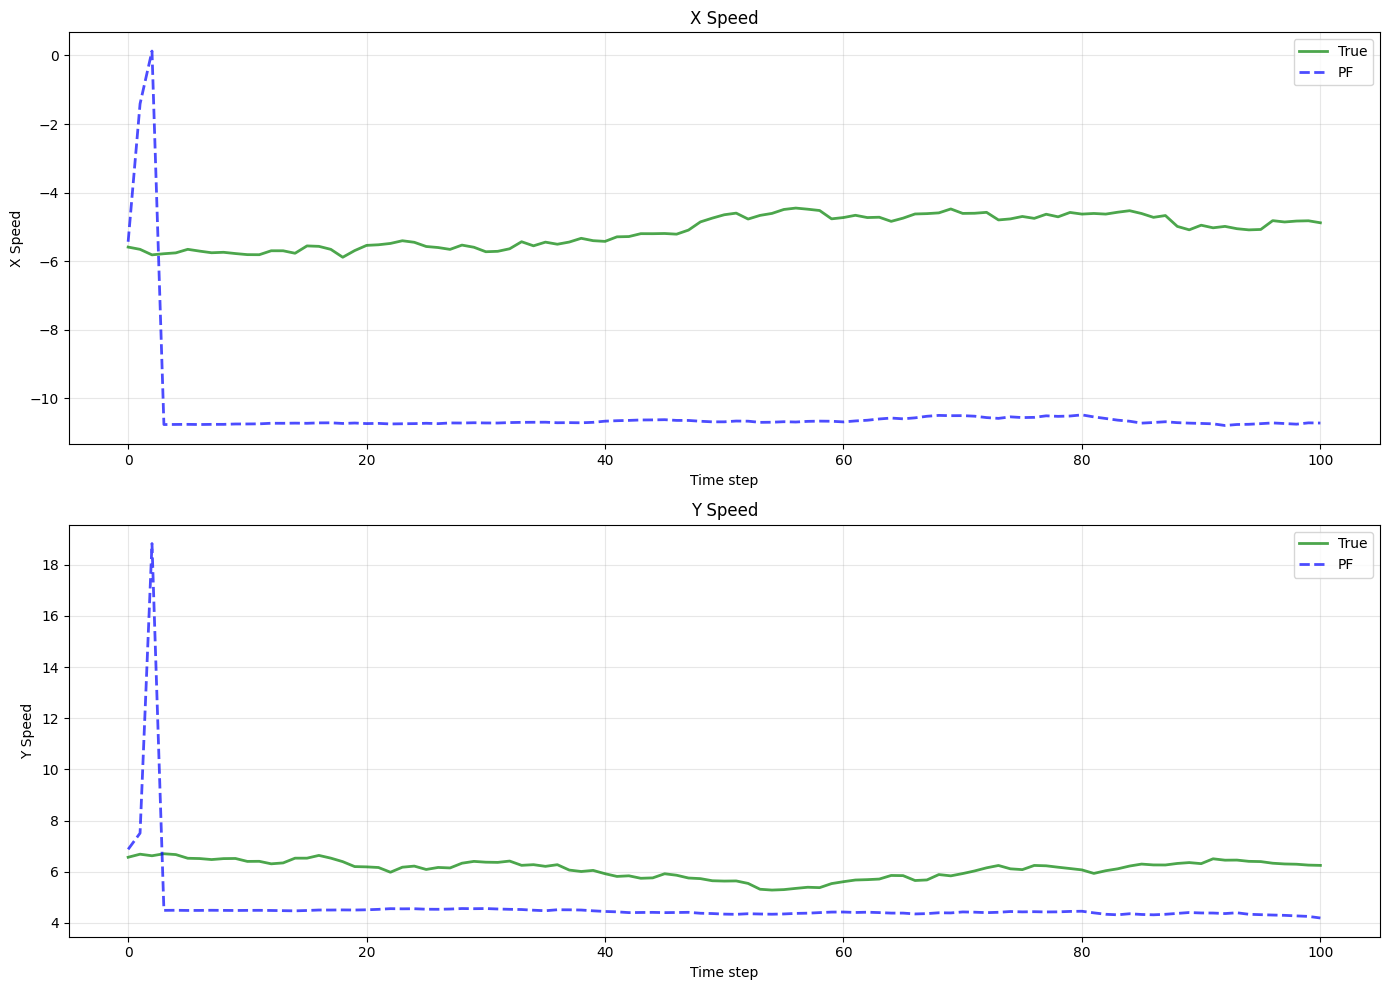

In [21]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# X Speed
ax = axes[0]
state_time = np.arange(0, T+1)
ax.plot(state_time, true_np[1, :], 'g-', linewidth=2, label='True', alpha=0.7)
ax.plot(state_time, filtered_np[1, :], 'b--', linewidth=2, label='PF', alpha=0.7)
ax.set_xlabel('Time step')
ax.set_ylabel('X Speed')
ax.set_title('X Speed')
ax.grid(True, alpha=0.3)
ax.legend()

# Y Speed
ax = axes[1]
ax.plot(state_time, true_np[3, :], 'g-', linewidth=2, label='True', alpha=0.7)
ax.plot(state_time, filtered_np[3, :], 'b--', linewidth=2, label='PF', alpha=0.7)
ax.set_xlabel('Time step')
ax.set_ylabel('Y Speed')
ax.set_title('Y Speed')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

## 6. Visualize Particle Degeneracy

Particle degeneracy occurs when most particle weights become negligible, leaving only a few particles with significant weights. This is monitored using:
- **Effective Sample Size (ESS)**: N_eff = 1 / Σ(w_i²)
- **Weight Distribution**: Visualization of particle weight concentration over time

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (100,) and arg 1 with shape (101,).

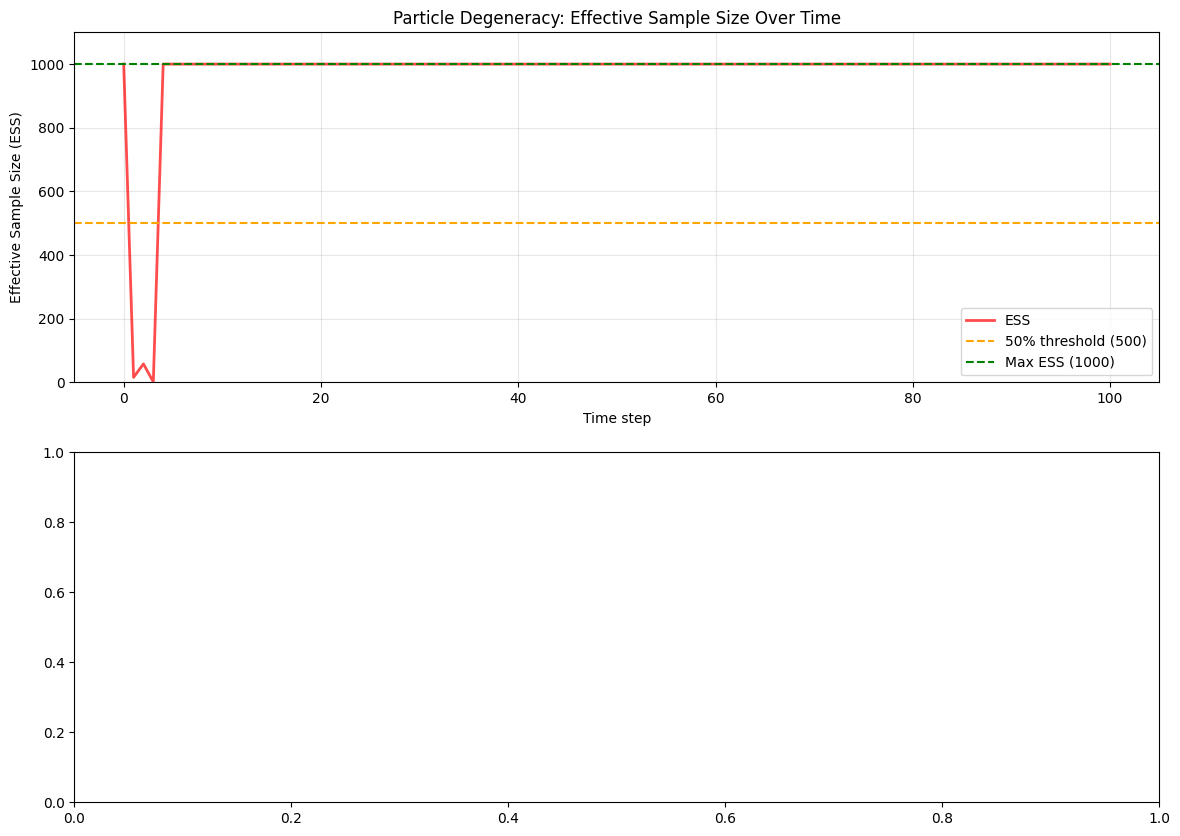

In [22]:
# Visualize Effective Sample Size (ESS) over time
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# ESS over time
ax = axes[0]
time_steps_ess = np.arange(0, T+1)
ess_np = ess_history.numpy()
ax.plot(time_steps_ess, ess_np, 'r-', linewidth=2, label='ESS', alpha=0.7)
ax.axhline(y=pf.num_particles/2, color='orange', linestyle='--', linewidth=1.5, label=f'50% threshold ({pf.num_particles/2:.0f})')
ax.axhline(y=pf.num_particles, color='g', linestyle='--', linewidth=1.5, label=f'Max ESS ({pf.num_particles})')
ax.set_xlabel('Time step')
ax.set_ylabel('Effective Sample Size (ESS)')
ax.set_title('Particle Degeneracy: Effective Sample Size Over Time')
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_ylim([0, pf.num_particles * 1.1])

# Resampling indicators
ax = axes[1]
resample_np = resample_history.numpy()
ax.bar(time_steps_ess[1:], resample_np, width=1.0, color='blue', alpha=0.6, label='Resampling occurred')
ax.set_xlabel('Time step')
ax.set_ylabel('Resampling')
ax.set_title('Resampling Events')
ax.set_ylim([0, 1.5])
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

print(f"\nParticle Degeneracy Statistics:")
print(f"  Average ESS: {np.mean(ess_np):.2f}")
print(f"  Min ESS: {np.min(ess_np):.2f}")
print(f"  Max ESS: {np.max(ess_np):.2f}")
print(f"  Resampling rate: {np.sum(resample_np)/len(resample_np)*100:.1f}%")

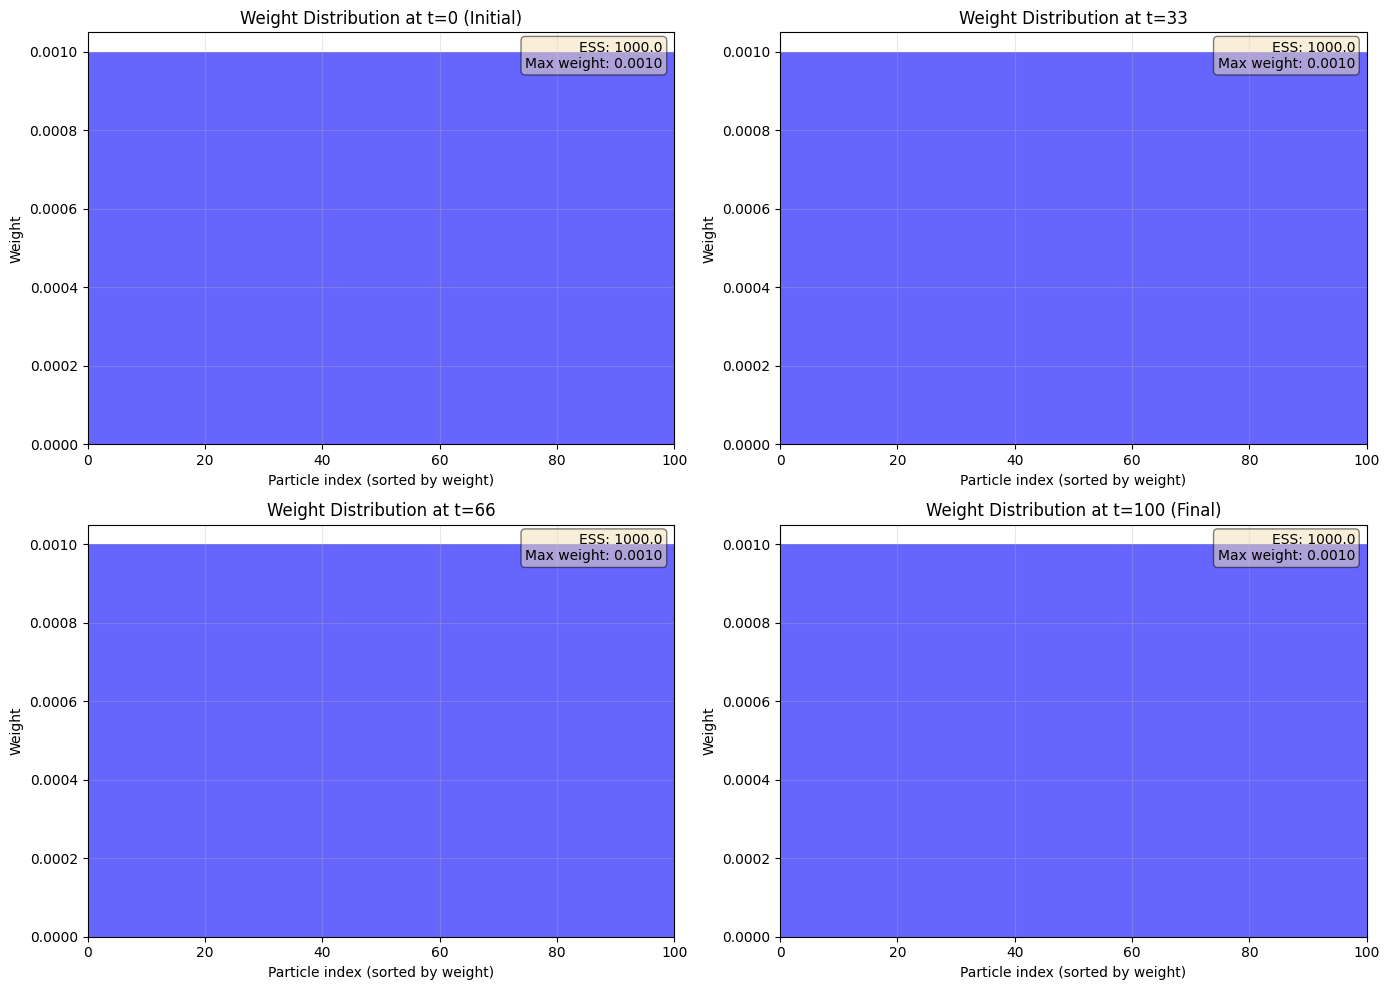

In [23]:
# Visualize weight distribution at different time steps
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Select time steps to visualize
time_indices = [0, T//3, 2*T//3, T]
titles = ['t=0 (Initial)', f't={T//3}', f't={2*T//3}', f't={T} (Final)']

for idx, (t_idx, title) in enumerate(zip(time_indices, titles)):
    ax = axes[idx // 2, idx % 2]
    
    # Get weights at this time step
    weights_t = weights_history[:, t_idx].numpy()
    
    # Sort weights in descending order
    sorted_weights = np.sort(weights_t)[::-1]
    
    # Plot weight distribution
    ax.bar(range(len(sorted_weights)), sorted_weights, width=1.0, color='blue', alpha=0.6)
    ax.set_xlabel('Particle index (sorted by weight)')
    ax.set_ylabel('Weight')
    ax.set_title(f'Weight Distribution at {title}')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, min(100, pf.num_particles)])  # Show only first 100 particles
    
    # Add statistics
    ess_t = ess_history[t_idx].numpy()
    max_weight = np.max(weights_t)
    ax.text(0.98, 0.98, f'ESS: {ess_t:.1f}\nMax weight: {max_weight:.4f}',
            transform=ax.transAxes, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()